# CHE1147 Data Mining in Engineering
### Assignment 6 Jialin Shang 1005086256
## 1 Model Performance
### 1.1 Dataset size vs model performance
Here, you will quantify the relationship between the dataset size and the model perfor-
mance. Essentially, you will answer the question: how much data is enough to model client
behaviour? In order to do this, you will pick the best single tree model you created in As-
signment #5 and evaluate it with datasets of different sizes using the monthly features you
created in Assignment #3.
Perform the evaluation with the following steps:
1. Split the train/test sets with 9:1 ratio This split should give you approximately 291k/32k
samples in train/test set, respectively.

In [1]:
# Import all packages we need
import numpy as np
import pandas as pd
from sklearn import preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Import dataset "days_since_last_txn.xlsx"
df_day = pd.read_excel("days_since_last_txn.xlsx")
df_day = df_day.iloc[:,1:]
df_day.head()

,CLNT_NO,ME_DT,days_since_last_txn
0,CS1112,2011-05-31,50
1,CS1112,2011-06-30,15
2,CS1112,2011-07-31,46
3,CS1112,2011-08-31,12
4,CS1112,2011-09-30,42


In [3]:
# Import dataset "mth_day_counts.xlsx"
df_count = pd.read_excel("mth_day_counts.xlsx")
df_count = df_count.iloc[:, 1:]
df_count.head()

,CLNT_NO,ME_DT,cnt-Friday,cnt-Monday,cnt-Saturday,cnt-Sunday,cnt-Thursday,cnt-Tuesday,cnt-Wednesday
0,CS5529,2011-05-31,0,1,0,0,0,0,0
1,CS5529,2011-06-30,0,0,0,0,0,1,0
2,CS5529,2011-07-31,0,0,1,1,0,0,0
3,CS5529,2011-08-31,0,0,0,0,0,0,0
4,CS5529,2011-09-30,0,0,0,0,0,0,0


In [4]:
# Import dataset "mth_rolling_features.xlsx"
df_rolling = pd.read_excel("mth_rolling_features.xlsx")
df_rolling = df_rolling.iloc[:,1:].replace(np.nan,0)
df_rolling.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Merge two data frames together 
df_merge = pd.merge(df_day, df_count, how = 'left', on = ['CLNT_NO', 'ME_DT'])
df_merge = pd.merge(df_merge, df_rolling, how = 'left', on = ['CLNT_NO', 'ME_DT'])
df_merge = df_merge.replace(np.nan, 0)
df_merge_data = df_merge.iloc[:,2:]
df_merge_data.head()

,days_since_last_txn,cnt-Friday,cnt-Monday,cnt-Saturday,cnt-Sunday,cnt-Thursday,cnt-Tuesday,cnt-Wednesday,mth_txn_amt_sum,mth_txn_cnt,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,50,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15,0,0,0,0,0,0,1,56,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,46,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,1,0,0,0,0,0,0,96,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Import dataset "Retail_Data_Response.csv" and label the 'response' values
df_customer = pd.read_csv("Retail_Data_Response.csv")
label = list(np.array(df_customer['response']))
# After labelling, rename the column name 
df_customer = df_customer.rename({'customer_id': 'CLNT_NO'}, axis = 'columns')

In [7]:
# Construct dataframe for monthly feature outputs 
monthly_features_outputs = pd.merge(df_merge, df_customer, how = 'left', on = ['CLNT_NO'])
monthly_features_outputs = monthly_features_outputs.replace(np.nan,0)
monthly_features_outputs.head()

,CLNT_NO,ME_DT,days_since_last_txn,cnt-Friday,cnt-Monday,cnt-Saturday,cnt-Sunday,cnt-Thursday,cnt-Tuesday,cnt-Wednesday,...,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,response
0,CS1112,2011-05-31,50,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CS1112,2011-06-30,15,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CS1112,2011-07-31,46,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CS1112,2011-08-31,12,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CS1112,2011-09-30,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Drop CLNT_NO, ME_DT and response for X_annual
monthly_x = monthly_features_outputs.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)
monthly_y = monthly_features_outputs['response']
# Split the data in train and test set according to ratio 9 : 1
X_train, X_test, y_train, y_test = train_test_split(monthly_x, monthly_y, test_size = 0.1, random_state = 1147)

In [9]:
# Verify that the training set : test set is 9 : 1
print(len(X_train))
print(len(X_test))
print(round(len(X_train)/len(X_test)))

291404
32379
9


2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree model with the N samples and evaluate the test set AUC. Repeat the sampling process 10 times and append the test set AUC.

In [20]:
def tree_model(N):
    # Construct an empty list to store the test accuracy value.
    auc_test = []
    # Construct a for loop 
    for idx in range(10):
        
        X_train_samples = X_train.sample(n = N)
        idx = X_train_samples.index
        y_train_samples = y_train[idx]

        dt_classifier = DecisionTreeClassifier(max_depth = 6, random_state = 1147, class_weight = 'balanced')
        dt_classifier.fit(X_train_samples, y_train_samples)

        scores_test  = dt_classifier.predict_proba(X_test)[:,1]
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        auc_test.append(auc(fpr_test, tpr_test))

        # Calculate the mean and standard deviation 
        mean_auc_test = np.mean(auc_test)
        std_auc_test = np.std(auc_test)
        
    return auc_test, mean_auc_test, std_auc_test

In [21]:
auc_test, mean_auc_test, std_auc_test = tree_model(50)
test_auc_table = {'sample': np.arange(1,11),'Test AUC': auc_test}
pd.DataFrame(test_auc_table).style.hide_index()

/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_26189/3197200435.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  pd.DataFrame(test_auc_table).style.hide_index()


sample,Test AUC
1,0.505548
2,0.534238
3,0.501795
4,0.503775
5,0.472410
6,0.496427
7,0.512966
8,0.516820
9,0.499740
10,0.499418


In [22]:
# calculate the mean and standard deviation of the test AUC for N samples
print ('The mean of the AUC Test for 50 samples is', mean_auc_test)
print ('The standard deviation of the AUC Test for 50 samples is', std_auc_test)

The mean of the AUC Test for 50 samples is 0.5043137336317579
The standard deviation of the AUC Test for 50 samples is 0.015032784966690338


3. Repeat the procedure you performed in the previous step for different sample size N

In [23]:
# Construct a list with different sample size N
N_samples = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]
# Construct an empty list for storing the mean and standard deviation
list_mean = []
list_std = []
# Construct a for loop
for n in N_samples:
  auc_test, mean_auc_test, std_auc_test = tree_model(n)
  list_mean.append(mean_auc_test)
  list_std.append(std_auc_test)

4. Build a table that contains the values of:
Sample size N
Test AUC mean
Test AUC standard deviation

In [26]:
AUC_N_samples = {'N': N_samples, 
                'Test AUC mean': list_mean, 
                'Test AUC standard deviation': list_std}

pd.DataFrame(AUC_N_samples).style.hide_index()

/var/folders/k9/v7lydvwn3cng806yx8gl85ww0000gn/T/ipykernel_26189/2117314313.py:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  pd.DataFrame(AUC_N_samples).style.hide_index()


N,Test AUC mean,Test AUC standard deviation
100,0.513364,0.011536
500,0.529646,0.016493
1000,0.532950,0.019023
2500,0.557608,0.010846
5000,0.584130,0.008694
7500,0.590490,0.011797
10000,0.599182,0.005961
15000,0.607616,0.005940
20000,0.613184,0.002579


5. Using the matplotlib function errorbar, plot the model performance captured in the
test AUC mean and standard deviation as a function of the sample size. From this plot, can you estimate what is the minimum number of samples needed to model the behaviour adequately?

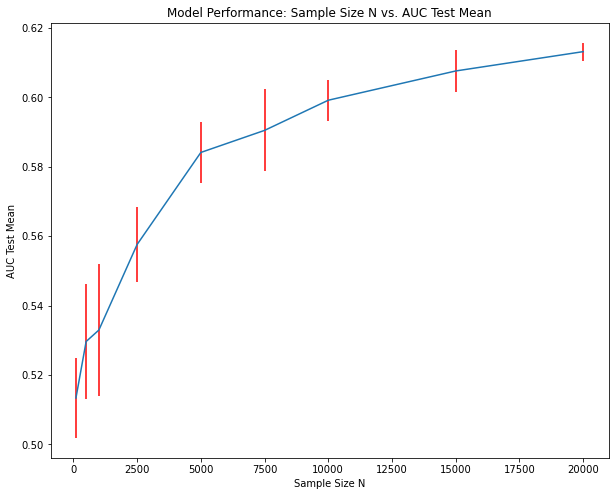

In [28]:
plt.figure(figsize = (10, 8))
plt.errorbar(N_samples, list_mean, yerr = list_std, ecolor = 'red') 
plt.title('Model Performance: Sample Size N vs. AUC Test Mean')
plt.xlabel('Sample Size N')
plt.ylabel('AUC Test Mean')
plt.show()

The above graph clearly indicates the mean of test AUC scores are increasing while at the same time, the standard deviations are decreasing. Before N = 5000, the AUC scores are dramatically increasing but after N = 5000, the growth of AUC scores slows down. Thus, the inflection point should be N = 5000 and so the minimum sample size for this decision tree model to behave well is 5000.